<a href="https://colab.research.google.com/github/AfnanAbdul/vision-interp/blob/main/notebooks/vision_interp_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Vision Interpretability and CNN Basics

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Let's say we have two grayscale images (10×10) one with an edge and one with a diagonal line:

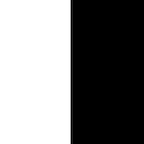

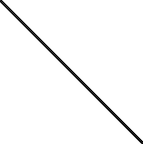

In [ ]:
# 10x10 grayscale image with a vertical edge
img_edge = torch.zeros(10, 10)
img_edge[:, 5:] = 1.0

# 10x10 grayscale image with a diagonal line
img_diag = torch.zeros(10, 10)
img_diag.fill_diagonal_(1.0)

print("Vertical edge:\n", img_edge)
print("\nDiagonal line:\n", img_diag)

Vertical edge:
 tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])

Diagonal line:
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0.,

In [ ]:
x_edge = img_edge.unsqueeze(0).unsqueeze(0) # [1, 1, 10, 10]
x_diag = img_diag.unsqueeze(0).unsqueeze(0)

We will use the following filters:

**Vertical-Edge Detection Kernel:**

$$K = \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}$$


This filter detects vertical edges (left-to-right changes).

How it works:
- It compares right vs left pixels in a 3×3 patch.
- Compute: (sum of right column) − (sum of left column) (the middle column is ignored because it's multiplied by 0).
- Output is large positive when the right side is brighter, large negative when the left side is brighter, and near 0 in uniform regions.

---

**Horizontal-Edge Detection Kernel:**

$$K_{\text{horz}} = \begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ 1 & 1 & 1 \end{bmatrix}$$

This filter detects horizontal edges (top-to-bottom changes).

How it works:
- It compares bottom vs top pixels in a 3×3 patch.
- Compute: (sum of bottom row) − (sum of top row) (the middle row is ignored because it's multiplied by 0).
- Output is large positive when the bottom is brighter, large negative when the top is brighter, and near 0 in uniform regions.

---

**Diagonal-Edge Detection Kernel:**

$$K_{\text{diag}} = \begin{bmatrix} 2 & -1 & -1 \\ -1 & 2 & -1 \\ -1 & -1 & 2 \end{bmatrix}$$

This filter detects diagonal edges (top-left to bottom-right orientation).

How it works:
- It emphasizes the main diagonal (top-left to bottom-right) with positive weights.
- It suppresses the off-diagonal elements with negative weights.
- Output is large positive when pixels along the main diagonal are brighter than surrounding pixels, and near 0 in uniform regions or when the pattern doesn't match the diagonal structure.

In [ ]:
k_vert = torch.tensor([[[[-1., 0., 1.],
                         [-1., 0., 1.],
                         [-1., 0., 1.]]]])
k_horz = torch.tensor([[[[-1., -1., -1.],
                         [ 0.,  0.,  0.],
                         [ 1.,  1.,  1.]]]])
k_diag = torch.tensor([[[[ 2., -1., -1.],
                          [-1.,  2., -1.],
                          [-1., -1.,  2.]]]])

Now we'll apply our three filters to both test images to see what happens.

This simple experiment reveals something fundamental about how neural networks see. When researchers use feature visualization to look inside trained CNNs like InceptionV1, they discover that the first layer has learned filters that look similar to our edge detectors.

Watch what happens when we apply each filter: the vertical edge detector will fire strongly on the vertical edge image but barely respond to the diagonal line. The diagonal detector does the opposite. Each filter is selective - it only cares about its specific pattern.

When you visualize the learned filters (weights) in the first convolutional layer of many CNNs, you often see filters that behave like edge detectorsand color-contrast detectors, similar to the filter we created. These observations provide evidence that early CNN layers learn relatively human-interpretable “building blocks”.

Let's see this in action:

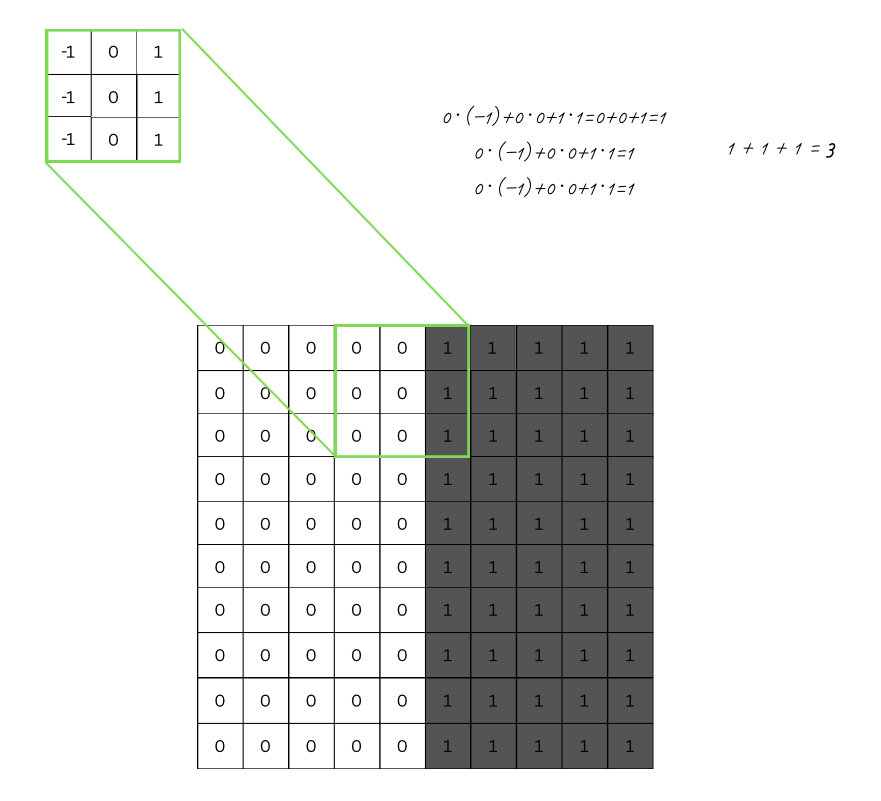

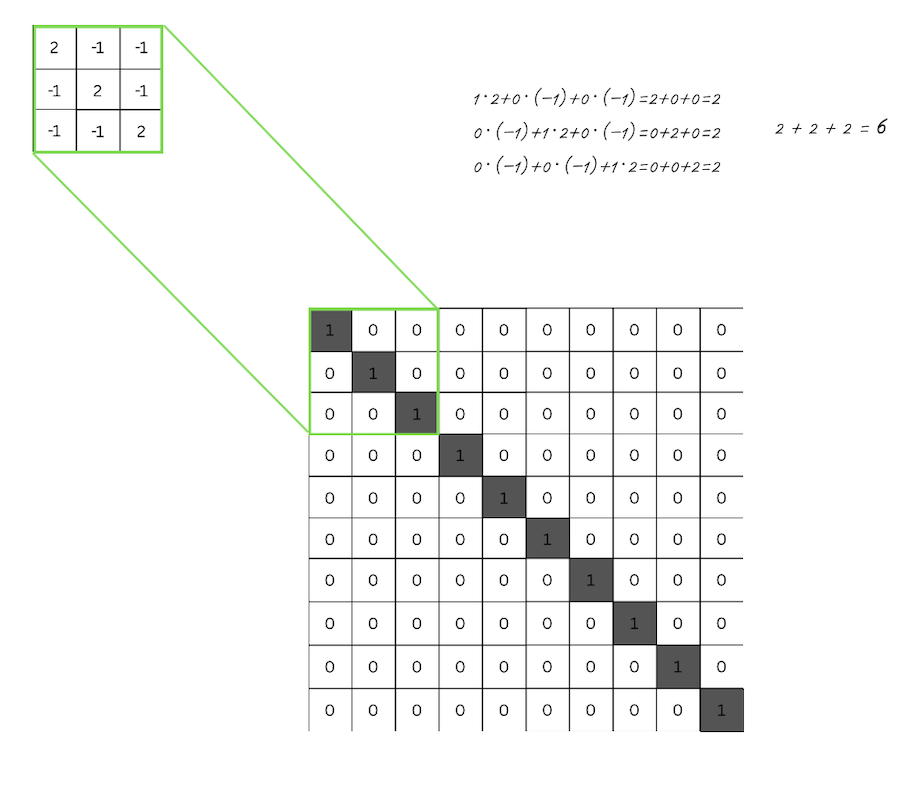

In [ ]:
y_edge_v = F.conv2d(x_edge, k_vert, padding=1)
y_edge_h = F.conv2d(x_edge, k_horz, padding=1)
y_edge_d = F.conv2d(x_edge, k_diag, padding=1)

y_diag_v = F.conv2d(x_edge, k_vert, padding=1)
y_diag_h = F.conv2d(x_edge, k_horz, padding=1)
y_diag_d = F.conv2d(x_diag, k_diag, padding=1)

In [ ]:
print("Vertical-edge image -> vertical filter output:\n", y_edge_v[0,0])
print("\nVertical-edge image -> horizontal filter output:\n", y_edge_h[0,0])
print("\nVertical-edge image -> diagonal filter output:\n", y_edge_d[0,0])

print("\nDiagonal-line image -> vertical filter output:\n", y_diag_v[0,0])
print("\nDiagonal-line image -> horizontal filter output:\n", y_diag_h[0,0])
print("\nDiagonal-line image -> diagonal filter output:\n", y_diag_d[0,0])

Vertical-edge image -> vertical filter output:
 tensor([[ 0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0., -2.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0., -3.],
        [ 0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0., -2.]])

Vertical-edge image -> horizontal filter output:
 tensor([[ 0.,  0.,  0.,  0.,  1.,  2.,  3.,  3.,  3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


In [ ]:
def show_grid(t, title):
    # t is a 2D tensor (H,W)
    a = t.detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(a, cmap="gray", interpolation="nearest")
    ax.set_title(title)

    H, W = a.shape
    ax.set_xticks(range(W))
    ax.set_yticks(range(H))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)

    # write numbers in cells
    for i in range(H):
        for j in range(W):
            val = a[i, j]
            txt_color = "white" if val < 0 else "black"
            ax.text(j, i, f"{val:.0f}", ha="center", va="center", color=txt_color, fontsize=10)

    plt.tight_layout()
    plt.show()


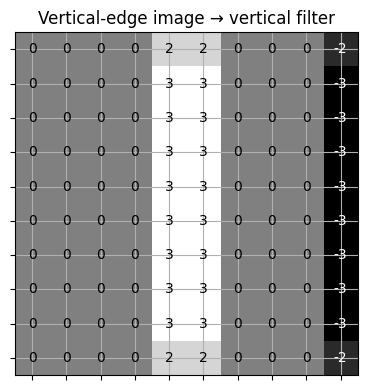

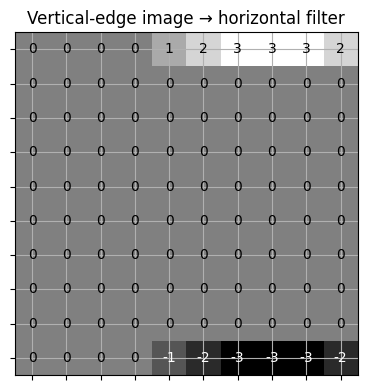

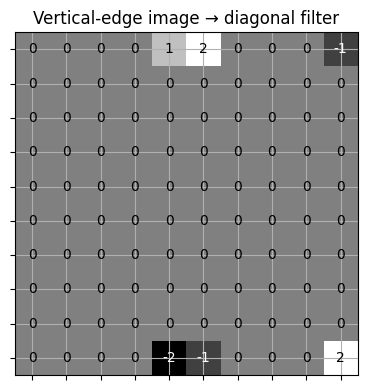

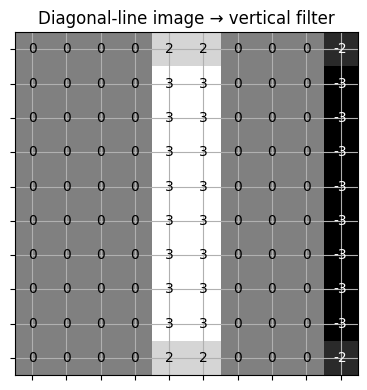

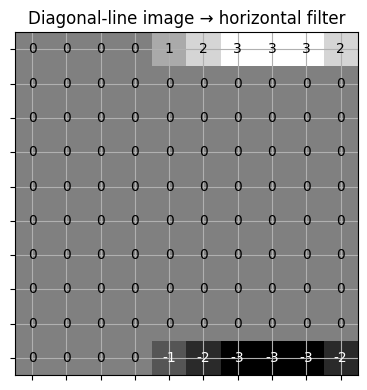

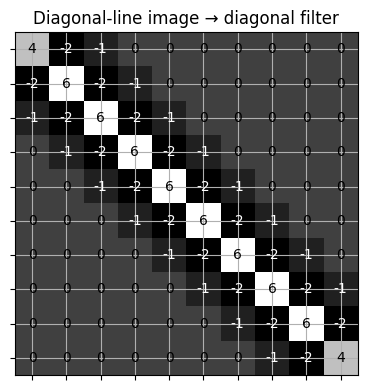

In [ ]:
# Visualize outputs (feature maps)
show_grid(y_edge_v[0,0], "Vertical-edge image → vertical filter")
show_grid(y_edge_h[0,0], "Vertical-edge image → horizontal filter")
show_grid(y_edge_d[0,0], "Vertical-edge image → diagonal filter")

show_grid(y_diag_v[0,0], "Diagonal-line image → vertical filter")
show_grid(y_diag_h[0,0], "Diagonal-line image → horizontal filter")
show_grid(y_diag_d[0,0], "Diagonal-line image → diagonal filter")

## Feature visualization: Activation Maximization
Using Lucent Library https://lucent.readthedocs.io/en/latest/index.html to get the activation maximization visualizations like in the Circuits thread for the first 10 neurons of Mixed4a Layer of InceptionV1


In [ ]:
!pip install -q torch-lucent

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.5/253.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.0 MB/s eta 0:00:00


In [ ]:
from lucent.optvis import render, param, transform, objectives
from lucent.misc.io import show
from lucent.modelzoo import inceptionv1
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [ ]:
model = inceptionv1(pretrained=True)
model.to(device).eval()

InceptionV1(
  (conv2d0_pre_relu_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2d1_pre_relu_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2d2_pre_relu_conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (mixed3a_1x1_pre_relu_conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_3x3_bottleneck_pre_relu_conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_5x5_bottleneck_pre_relu_conv): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_pool_reduce_pre_relu_conv): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_3x3_pre_relu_conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (mixed3a_5x5_pre_relu_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mixed3b_1x1_pre_relu_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (mixed3b_3x3_bottleneck_pre_relu_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (mixed3b_5x5_bottleneck_pre_relu_conv): Conv2d(256, 32, 

100%|██████████| 512/512 [00:15<00:00, 32.06it/s]



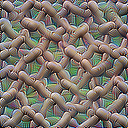
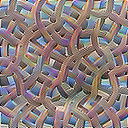
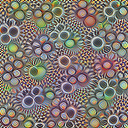
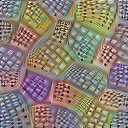
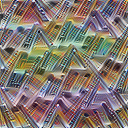
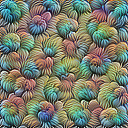
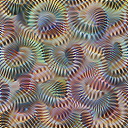
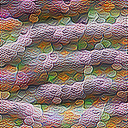
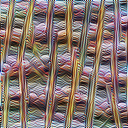
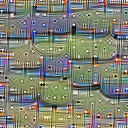

In [ ]:
images = []
for i in range(10):
    img = render.render_vis(model, objectives.channel("mixed4a", i))
    images.append(img[0])

show(images)